# Accuracy of alternative data sources for temparature data
### Matti Meikäläinen
### 22 March, 2024

# Motivation

The motivation of the study was to investigate whether the temperature data from the Finnish Meteorological Institute (FMI) could be replaced with the Open-Meteo (OpM) data that are computationally easier to retrieve. In this pilot, I focus on developing the methods that can be applied in a more detailed investigation using a longer timespan and a greater number of localoties.

# Materials and methods

## Retrieval of FMI data

The FMI data were manually retrieved on 8 February, 2024, using the web interface at [https://en.ilmatieteenlaitos.fi/download-observations](https://en.ilmatieteenlaitos.fi/download-observations). The chosen measurement was 'Average temperature' under 'Hourly observations' within 'Weather observations'. The chosen timespan was '1.1.2024-31.1.2024' and the chosen observation stations were 'Helsinki Malmi airfield' and 'Helsinki Vuosaari harbour'. The obeervations were downloaded in 'CSV format'.

The CSV data were converted to TSV format using the following 'convert_FMI.sh' script:

In [193]:
%%bash

cat > convert_FMI.sh << 'EOF'
#!/usr/bin/bash
sed -n 2,\$p $1 | sed 's/[\"\r]//g;s/,/\t/g;s/ /_/g' \
| awk '{printf "%d-%02d-%02dT%s\t%.1f\n",$2,$3,$4,$5,$6}'
EOF

This script removes the doublequotes and CR characters and connects the observation station's name into one word with underscores. In the second part, the location field is dropped and the date field is converted to the format used in the OpM data. For the manually downloaded files, the conversion was done like this:

In [194]:
%%bash

bash convert_FMI.sh data/Malmi_airfield_1.1.2024-31.1.2024.csv \
 > data/Malmi_FMI.tsv
    
bash convert_FMI.sh data/Vuosaari_harbour_1.1.2024-31.1.2024.csv \
 > data/Vuosaari_FMI.tsv

## Retrieval of OpM data

The command for downloading the OpM data were manually constructed using the web interface at [https://open-meteo.com/en/docs/historical-weather-api](https://open-meteo.com/en/docs/historical-weather-api). The coordinates for 'Helsinki-Malmi Airport' and 'Vuosaari (Uusimaa)' were searched using the Search box and the 'Timezone' was set to 'Automatically detect'. The Start and End Date were set as '2024-01-01' and '2024-01-31' and 'Temperature (2 m)' was selected under 'Hourly Weather Variables'. 'Temperature Unit' was kept in its default, 'Celcius'. The JSON-formatted data were converted to TSV format using the program 'jq'. Joining together, the download and format conversion was done like this:

In [195]:
%%bash

curl "https://archive-api.open-meteo.com/v1/archive?hourly=temperature_2m&\
latitude=60.2546&longitude=25.0428&start_date=2024-01-01&end_date=2024-01-31&\
timezone=auto" \
| jq -r '[.hourly.time,.hourly.temperature_2m] | transpose[] | @tsv' \
> data/Malmi_OpM.tsv
    
curl "https://archive-api.open-meteo.com/v1/archive?hourly=temperature_2m&\
latitude=60.2096&longitude=25.142&start_date=2024-01-01&end_date=2024-01-31&\
timezone=auto" \
| jq -r '[.hourly.time,.hourly.temperature_2m] | transpose[] | @tsv' \
> data/Vuosaari_OpM.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18237    0 18237    0     0  64505      0 --:--:-- --:--:-- --:--:-- 64670
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18230    0 18230    0     0   103k      0 --:--:-- --:--:-- --:--:--  104k


For the convenience, the data files for each locality were joined into one file, using the date field as the join key: 

In [196]:
%%bash

(echo "Date FMI OpM" && join data/Malmi_{FMI,OpM}.tsv) > data/Malmi.tsv
(echo "Date FMI OpM" && join data/Vuosaari_{FMI,OpM}.tsv) > data/Vuosaari.tsv

The resulting files for statistical analyses are thus `data/Malmi.tsv` and `data/Vuosaari.tsv`.

## Statistical analyses

The statistical analyses and data visualisation were performed using the Python packages pandas, numpy and matplotlib.

In [197]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

First, the two data files were merged into one dataframe:

In [198]:
dat_m = pd.read_csv('data/Malmi.tsv',sep=" ")
dat_v = pd.read_csv('data/Vuosaari.tsv',sep=" ")

dat = pd.merge(dat_m, dat_v, on="Date")
dat.columns = ['Date','Malmi_FMI','Malmi_OpM','Vuosaari_FMI','Vuosaari_OpM']

After that, the pandas commands `corr` was used to compute pairwise correlation of columns:

In [203]:
dat.drop(['Date'],axis=1).corr()

,Malmi_FMI,Malmi_OpM,Vuosaari_FMI,Vuosaari_OpM
Malmi_FMI,1.000000,0.948093,0.982119,0.944767
Malmi_OpM,0.948093,1.000000,0.964481,0.997860
Vuosaari_FMI,0.982119,0.964481,1.000000,0.961268
Vuosaari_OpM,0.944767,0.997860,0.961268,1.000000


To understand the reasons for the deviations, the observations across time were plotted together:

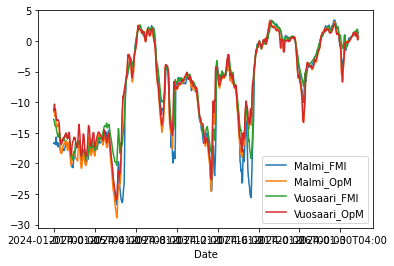

In [200]:
plot = dat.plot('Date',['Malmi_FMI','Malmi_OpM','Vuosaari_FMI','Vuosaari_OpM'])

The plot indicated that the temperature measurements have reached lower values in Malmi. This was studied more closely by plotting the measurements for the observation stations as histograms:

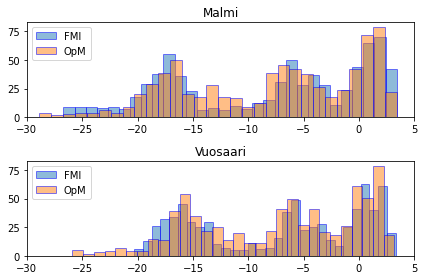

In [201]:
fig, axes = plt.subplots(nrows=2,ncols=1)

axes[0].hist(dat.Malmi_FMI, bins=30, edgecolor='b', alpha=0.5, label='FMI')
axes[0].hist(dat.Malmi_OpM, bins=30, edgecolor='b', alpha=0.5, label='OpM')
axes[0].set_title('Malmi')
axes[0].set_xlim([-30,5])
axes[0].legend()

axes[1].hist(dat.Vuosaari_FMI, bins=30, edgecolor='b', alpha=0.5, label='FMI')
axes[1].hist(dat.Vuosaari_OpM, bins=30, edgecolor='b', alpha=0.5, label='OpM')
axes[1].set_title('Vuosaari')
axes[1].set_xlim([-30,5])
axes[1].legend()

fig.tight_layout()
plt.show()

and as pairwise scatter plots:

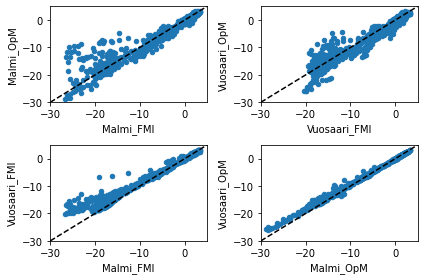

In [202]:
p1 = [1,1,3,2]
p2 = [2,3,4,4]
rc = [0,1,0,1]
cc = [0,0,1,1]

fig, axes = plt.subplots(2, 2)

for i in range(4):
    plot = dat.plot.scatter(p1[i], p2[i], 
                ax=axes[rc[i], cc[i]], xlim=[-30,5], ylim=[-30,5])
    plot.axline((1, 1), slope=1, color='k', ls='--')

fig.tight_layout()
plt.show()


# Results

To be finished. Something about 

- Lower temperatures in Malmi than in Vuosaari. Is that because of the sea?
- Vuosaari FMI and OpM correlate really nicely! What's wrong with Malmi?
- In fact, Malmi_FMI and Vuosaari_FMI correlate pretty ok. Is the Malmi_Opm the weird one?

# Discussion

To be finished. Something about 

- I don't know the sources of the FMI and OpM data. Are there really that many observation stations at the Malmi airfield?
- In fact, Vuosaari_OpM is from *Vuosaari*, not from the Vuosaari harbour. Despite that, the correlation between FMI and OpM is good!
- I should remember the motivation of this whole exercise and say something about the quality of the Open-Meteo data.
- Should I spend some time to learn the API for the FMI data? That would solve the problem as well!